In [3]:
from collections import defaultdict

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from mcda.dataset import MCDADataset
from mcda.report import calculate_heuristics
from mcda.uta import Criterion, check_uta_feasibility
from methods.autoencoder import DominanceAutoEncoder
from methods.mvu import MaximumVarianceUnfolding

sns.set()

In [34]:
df = MCDADataset.read_csv("./data/insulating-materials/dataset.csv").data

In [82]:
methods = {
    "PCA": Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2, random_state=42))]),
    "KernelPCA": Pipeline([("scaler", StandardScaler()), ("kpca", KernelPCA(n_components=2, random_state=42, kernel="sigmoid"))]),
    "Isomap": Pipeline([("scaler", StandardScaler()), ("isomap", Isomap(n_components=2))]),
    "MVU": Pipeline([("scaler", StandardScaler()), ("mvu", MaximumVarianceUnfolding(n_components=2, seed=42))]),
    "DAE": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("dae", DominanceAutoEncoder(latent_dim=2, num_epochs=1000, random_state=42, verbose=False)),
        ]
    ),
}

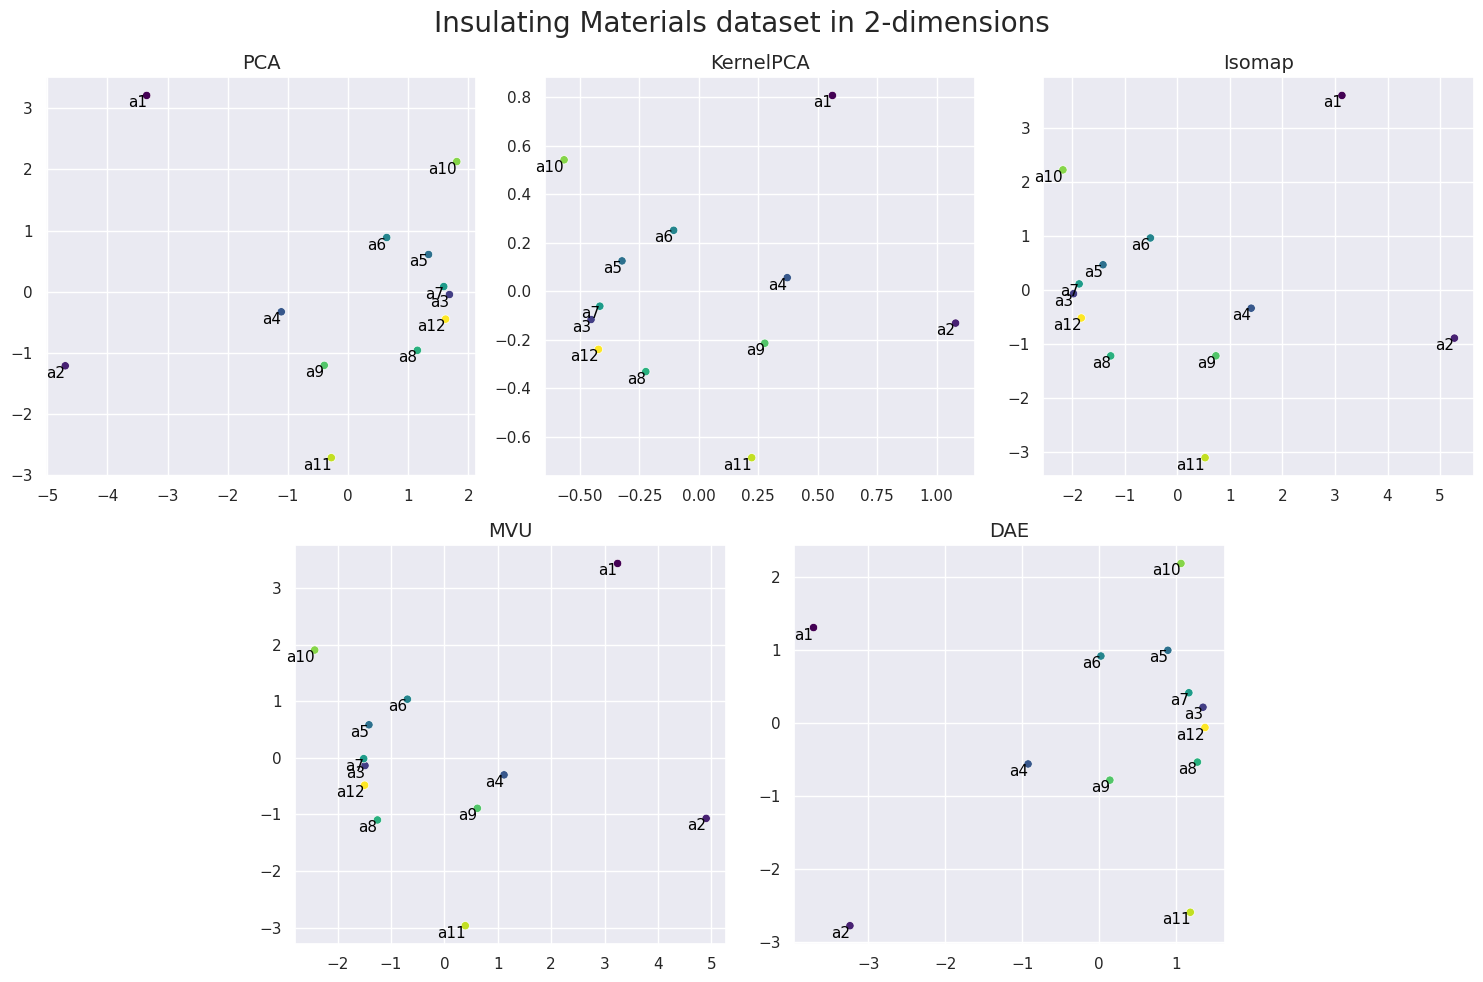

In [83]:
fig = plt.figure(figsize=(15, 10))

# Create a 2x6 grid (for finer control)
gs = gridspec.GridSpec(2, 6)
axes = []
axes.append(plt.subplot(gs[0, 0:2]))  # PCA spans columns 0-1
axes.append(plt.subplot(gs[0, 2:4]))  # KernelPCA spans columns 2-3
axes.append(plt.subplot(gs[0, 4:6]))  # Isomap spans columns 4-5
axes.append(plt.subplot(gs[1, 1:3]))  # MVU spans columns 1-2
axes.append(plt.subplot(gs[1, 3:5]))  # DAE spans columns 3-4

color = np.linspace(0, 1, df.shape[0])

for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2"])
    sns.scatterplot(
        x="Dim 1",
        y="Dim 2",
        hue=color,
        palette="viridis",
        data=df_m,
        ax=axes[i],
        legend=False,
    )
    for j in range(df_m.shape[0]):
        axes[i].text(
            df_m.iloc[j, 0],
            df_m.iloc[j, 1],
            str(df_m.index[j]),
            fontsize=11,
            color="black",
            ha="right",
            va="top",
        )
    axes[i].set_title(f"{method_name}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.suptitle("Insulating Materials dataset in 2-dimensions", fontsize=20)
plt.tight_layout()
plt.savefig("./data/insulating-materials/2d-plane.png")
plt.show()

In [84]:
dfs = pd.DataFrame(index=df.index)
for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2"])    
    for col in df_m.columns:
        dfs[f"{method_name}_{col}"] = df_m[col]
dfs.columns = pd.MultiIndex.from_tuples([(x.split("_")[0], x.split("_")[1]) for x in dfs.columns])
dfs

PCA           KernelPCA              Isomap                 MVU  \
        Dim 1     Dim 2     Dim 1     Dim 2     Dim 1     Dim 2     Dim 1   
a1  -3.346876  3.211492  0.561936  0.806559  3.132092  3.592552  3.245172   
a2  -4.699118 -1.212806  1.080259 -0.131280  5.273992 -0.889742  4.904602   
a3   1.684122 -0.046778 -0.453771 -0.116591 -1.979372 -0.069624 -1.486136   
a4  -1.109506 -0.329347  0.371856  0.055930  1.404000 -0.336844  1.118401   
a5   1.337065  0.608853 -0.323475  0.124977 -1.417860  0.464894 -1.412427   
a6   0.641583  0.886587 -0.106171  0.251072 -0.515397  0.959906 -0.692452   
a7   1.589505  0.083771 -0.416853 -0.061544 -1.871962  0.111599 -1.511142   
a8   1.151904 -0.959108 -0.223393 -0.331118 -1.271432 -1.217943 -1.253052   
a9  -0.395974 -1.205738  0.277292 -0.214218  0.731666 -1.216719  0.618447   
a10  1.805717  2.129326 -0.567210  0.541381 -2.180908  2.217918 -2.429196   
a11 -0.278657 -2.716918  0.222206 -0.685756  0.526198 -3.098561  0.392077   
a12  1.620235 -0.449333 -0.422678 -0.239412 -1.831017 -0.517435 -1.494295   

                    DAE            
        Dim 2     Dim 1     Dim 2  
a1   3.434778 -3.744703  1.301019  
a2  -1.070114 -3.271704 -2.712433  
a3  -0.136412  1.389264  0.182544  
a4  -0.300820 -0.924496 -0.542103  
a5   0.583768  0.935343  0.962626  
a6   1.036576  0.042455  0.898579  
a7  -0.014573  1.204578  0.382986  
a8  -1.097695  1.301529 -0.549232  
a9  -0.891204  0.127967 -0.759430  
a10  1.904885  1.121523  2.135560  
a11 -2.966030  1.198263 -2.563405  
a12 -0.483159  1.410611 -0.090428

In [73]:
def format_float(x):
    return f"{x:.3f}"

formatted_dfs = dfs.map(format_float)
latex_table = formatted_dfs.to_latex(
    multicolumn=True,
    multicolumn_format='c',
    multirow=True,
    caption='Dimensionality Reduction Methods Comparison',
    label='tab:dim_reduction',
    column_format="|l|" + "r|"*10
)
print(latex_table)

\begin{table}
\caption{Dimensionality Reduction Methods Comparison}
\label{tab:dim_reduction}
\begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|}
\toprule
 & \multicolumn{2}{c}{PCA} & \multicolumn{2}{c}{KernelPCA} & \multicolumn{2}{c}{Isomap} & \multicolumn{2}{c}{MVU} & \multicolumn{2}{c}{DAE} \\
 & Dim 1 & Dim 2 & Dim 1 & Dim 2 & Dim 1 & Dim 2 & Dim 1 & Dim 2 & Dim 1 & Dim 2 \\
\midrule
a1 & -3.347 & 3.211 & 0.647 & 0.461 & 3.132 & 3.593 & 3.245 & 3.435 & -3.745 & 1.301 \\
a2 & -4.699 & -1.213 & 0.693 & 0.335 & 5.274 & -0.890 & 4.905 & -1.070 & -3.272 & -2.712 \\
a3 & 1.684 & -0.047 & -0.471 & -0.003 & -1.979 & -0.070 & -1.486 & -0.136 & 1.389 & 0.183 \\
a4 & -1.110 & -0.329 & 0.357 & -0.290 & 1.404 & -0.337 & 1.118 & -0.301 & -0.924 & -0.542 \\
a5 & 1.337 & 0.609 & -0.416 & 0.227 & -1.418 & 0.465 & -1.412 & 0.584 & 0.935 & 0.963 \\
a6 & 0.642 & 0.887 & -0.283 & 0.120 & -0.515 & 0.960 & -0.692 & 1.037 & 0.042 & 0.899 \\
a7 & 1.590 & 0.084 & -0.479 & 0.028 & -1.872 & 0.112 & -1.511 & -0.015 & 1.2